In [21]:
import os
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchmetrics import (
    Accuracy,
    MetricCollection,
    JaccardIndex,
    F1Score,
    MeanSquaredError,
)
import segmentation_models_pytorch as smp
from pytorch_toolbelt.losses import JaccardLoss, BinaryFocalLoss
from torch.utils.data import Dataset, random_split, DataLoader

from pytorch_lightning import Trainer
from typing import Any, Tuple, Optional, Callable, cast

import matplotlib.pyplot as plt
import wandb
import tqdm as notebook_tqdm
import random

from glob import glob
import pandas as pd
import seaborn as sns

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [4]:
import segmentation_models_pytorch as smp

In [5]:
pl.seed_everything(30)

Global seed set to 30


30

In [6]:
wandb.login()

wandb: Currently logged in as: sofstef (trees). Use `wandb login --relogin` to force relogin


True

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
%load_ext lab_black

In [9]:
os.chdir("/Users/sofija/Ai4er/mres/tree-segmentation")
os.getcwd()

'/Users/sofija/Ai4er/mres/tree-segmentation'

In [10]:
from src.datasets import TreeSegments
from src.evaluation import BinaryIoU
from src.datamodules import TreeDataModule
from src.models import UNet, SegModel
from src.evaluation import LogPredictionSamplesCallback

In [11]:
dm = TreeDataModule(
    data_dir="data/train/samples/",
    target_dir="data/train/segments/",
    test_data_dir="data/test/samples",
    test_target_dir="data/test/segments/",
    batch_size=15,
    num_workers=0,
    drop_last_batch=True,
)

In [17]:
dm.setup(stage="fit")
train_dl = dm.train_dataloader()

In [18]:
dm.setup(stage="test")
test_dl = dm.test_dataloader()

In [408]:
for sample in test_dl:
    image = sample[0]
    mask = sample[1]

In [387]:
mask.shape

torch.Size([5, 1, 128, 160])

In [388]:
sample_id

('64_148', '63_147', '62_146', '71_155', '70_154')

In [389]:
image.min()

tensor(-1.2701)

In [390]:
image.max()

tensor(2.3016)

In [392]:
image.shape

torch.Size([5, 1, 128, 160])

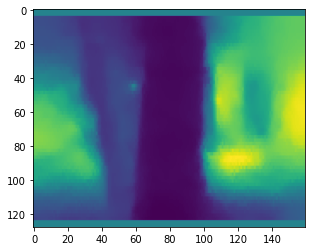

In [398]:
plt.imshow(torch.squeeze(image[4, :, :]))

## Loading model from a checkpoint


In [20]:
# callbacks = [
#     ModelCheckpoint(monitor="test_accuracy", mode="max"),
#     ModelCheckpoint(monitor="test_jaccard", mode="max"),
#     ModelCheckpoint(monitor="test_loss", mode="min", save_top_k=2),
#     ModelCheckpoint(monitor="test_f1", mode="max"),
# ]

In [12]:
best_path = "lightning_logs/colab_ckpt/epoch=78-step=632-v1.ckpt"

In [13]:
trained_model = SegModel.load_from_checkpoint(checkpoint_path=best_path)

In [14]:
trainer = Trainer()

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [412]:
tests = trainer.test(model=trained_model, dataloaders=dm)

Testing DataLoader 0: 100%|█████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7187344431877136
         test_f1            0.7891926169395447
      test_jaccard          0.7978360652923584
        test_loss           0.21581991016864777
        test_rmse           0.05078369006514549
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [413]:
tests

[{'test_loss': 0.21581991016864777,
  'test_accuracy': 0.7187344431877136,
  'test_jaccard': 0.7978360652923584,
  'test_f1': 0.7891926169395447,
  'test_rmse': 0.05078369006514549}]

### Inspecting test predictions

First, let's plot the input images and masks from the test dataset alongside predictions from the model trained on 80 samples. 

Images in the test dataset are normalised in the same way as images in the training dataset to get the correct predictions, but for visualization we want to 'unnormalize' the input images before plotting them. 

In [22]:
invNorm = transforms.Compose(
    [
        transforms.Normalize(mean=[0], std=[1 / 1.6713]),
        transforms.Normalize(mean=[-3.2749], std=[1.0]),
    ]
)

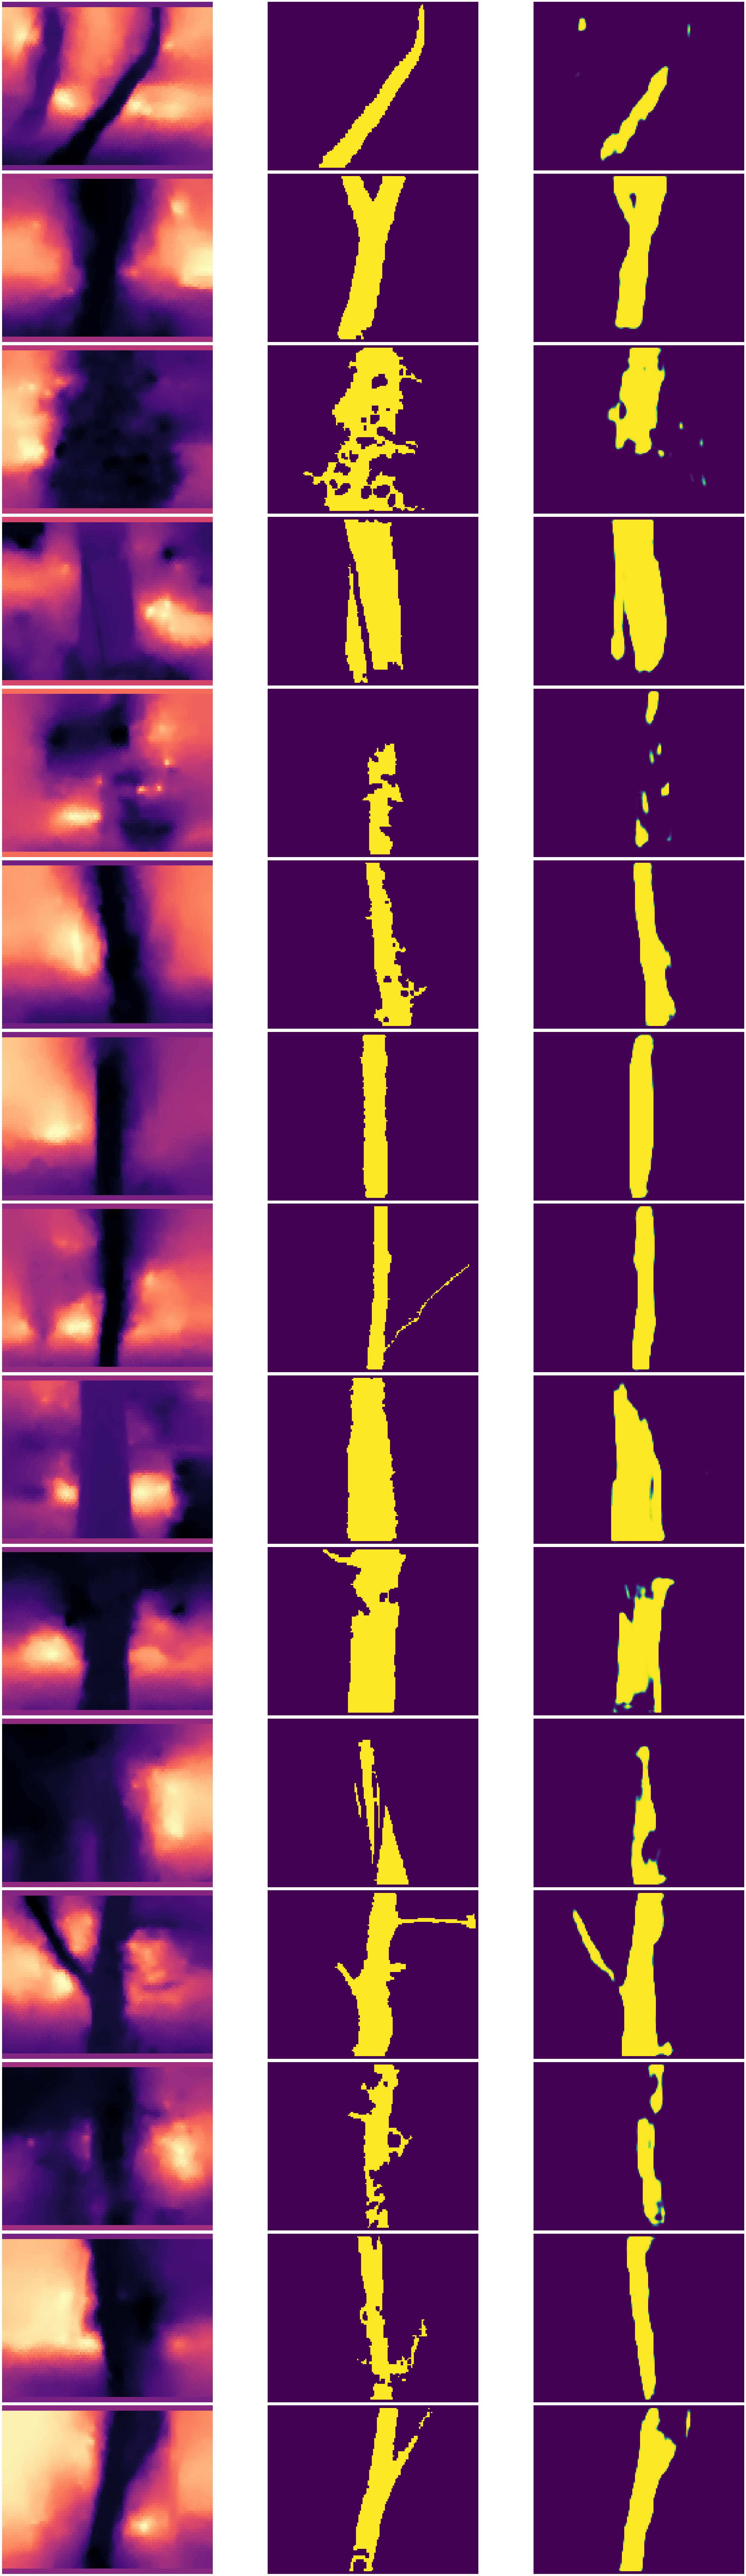

In [19]:
batch = next(iter(test_dl))
with torch.no_grad():
    trained_model.eval()
    logits = trained_model(batch[0])
pr_masks = logits.sigmoid()

n_row = batch[0].shape[0]

fig, ax = plt.subplots(n_row, 3, figsize=(40, 120))
cmap = "magma"
title_fontsize = 16
cbar_fontsize = 12

for i in range(n_row):
    image = torch.squeeze(invNorm(batch[0][i]))
    groundtruth = torch.squeeze(batch[1][i])
    # sample_id = batch[2][i]
    pred = torch.squeeze(pr_masks[i])

    difference = groundtruth - pred
    vmin = image.min()
    vmax = image.max()
    diffmax = np.abs(difference).max()
    # rmse = round(np.sqrt(np.mean(difference ** 2)), 4)

    im = ax[i, 0].imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    # cbar = plt.colorbar(im, orientation="vertical", ax=ax[i, 0], shrink=0.75)
    # cbar.ax.tick_params(labelsize=cbar_fontsize)
    ax[i, 0].axis("off")
    # ax[i, 0].set_title(f"Input depths for sample {sample_id}", fontsize=title_fontsize)

    im = ax[i, 1].imshow(groundtruth)
    ax[i, 1].axis("off")
    # ax[i, 1].set_title(f"Groundtruth", fontsize=title_fontsize)

    im = ax[i, 2].imshow(pred)
    ax[i, 2].axis("off")
    # ax[i, 2].set_title(f"Prediction", fontsize=title_fontsize)

    # im = ax[i, 3].imshow(difference)
    # ax[i, 3].axis('off')
    # ax[i, 3].set_title(f'Difference - RMSE {rmse}', fontsize=title_fontsize)

# plt.margins(x=0)
plt.tight_layout()

In [232]:
!cd "/Users/sofija/AndroidStudioProjects/trees/OfflineProcessing/v2_DepthAssistedSegmentation/arcore_samples/"

In [20]:
for i in range(n_row):
    image = torch.squeeze(invNorm(batch[0][i]))
    sample_id = batch[2][i]
    logits = pr_masks[i]
    mask = torch.squeeze((logits > 0.5).int(), dim=1)

    overlay = image * mask
    overlay = torch.squeeze(overlay[:, 4:-4, :]).numpy()

    df = pd.concat(
        [
            pd.DataFrame([[j, i, overlay[i, j]]], columns=["x", "y", "d"])
            for i in range(dims[0])
            for j in range(dims[1])
        ],
        ignore_index=True,
    )
    np.savetxt(f"Segmented_Sample_{sample_id}", df.values, delimiter=",", fmt="%.3f")

NameError: name 'pd' is not defined

In [ ]:
from scipy import stats

In [ ]:
m = stats.mode(loaded_img, axis=None)

In [ ]:
m

ModeResult(mode=array([0.]), count=array([14959]))

In [231]:
# batch = next(iter(test_dl))
# with torch.no_grad():
#     trained_model.eval()
#     logits = trained_model(batch[0])
# pr_masks = logits.sigmoid()

# for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):

#     image = invNorm(image)

#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(torch.squeeze(image))
#     plt.title("Image")
#     plt.axis("off")

#     plt.subplot(1, 3, 2)
#     plt.imshow(torch.squeeze(gt_mask))
#     plt.title("Ground truth")
#     plt.axis("off")

#     plt.subplot(1, 3, 3)
#     plt.imshow(torch.squeeze(pr_mask))
#     plt.title("Prediction")
#     plt.axis("off")

#     plt.show()

### Comparing diameters 

Here I compare the diameter estimates from the segmented depths, raw arcore depths and ToF depths.

In [327]:
results = pd.read_csv(
    "/Users/sofija/AndroidStudioProjects/trees/OfflineProcessing/v2_DepthAssistedSegmentation/arcore_results/results.csv"
)
arcore_baseline = pd.read_csv(
    "/Users/sofija/AndroidStudioProjects/trees/OfflineProcessing/v2_DepthAssistedSegmentation/arcore_baseline/results.csv"
)

In [328]:
results

,Unnamed: 0,sample_number,capture_number,trunk_depth_m,reference_width_m,estimated_width_m,angle_deg,error_m,percent_error
0,0,38.0,96.0,1.80,1.0,0.680184,-5.003545,-0.319816,31.981567
1,1,38.0,94.0,1.80,1.0,0.520090,3.741058,-0.479910,47.990971
2,2,38.0,95.0,1.80,1.0,0.555102,6.716706,-0.444898,44.489796
3,3,41.0,104.0,1.71,1.0,0.401456,-6.640356,-0.598544,59.854383
4,4,41.0,103.0,1.74,1.0,0.408499,-5.604515,-0.591501,59.150074
5,5,41.0,105.0,1.65,1.0,0.397768,-5.283504,-0.602232,60.223214
6,6,43.0,109.0,1.35,1.0,0.333979,-3.388805,-0.666021,66.602086
7,7,43.0,110.0,1.35,1.0,0.355423,-5.360372,-0.644577,64.457741
8,8,43.0,111.0,1.38,1.0,0.363321,-3.262930,-0.636679,63.667913
9,9,48.0,126.0,1.50,1.0,0.414104,-0.081752,-0.585896,58.589647


In [329]:
arcore_baseline

,Unnamed: 0,sample_number,capture_number,trunk_depth_m,reference_width_m,estimated_width_m,angle_deg,error_m,percent_error
0,0,38.0,96.0,1.80,1.0,0.803120,8.484620,-0.196880,19.687988
1,1,38.0,94.0,1.80,1.0,0.790654,-12.379029,-0.209346,20.934579
2,2,38.0,95.0,1.80,1.0,0.005049,55.160509,-0.994951,99.495091
3,3,41.0,104.0,1.71,1.0,0.417632,-6.114222,-0.582368,58.236783
4,4,41.0,103.0,1.77,1.0,0.437884,-7.244118,-0.562116,56.211624
5,5,41.0,105.0,1.65,1.0,0.418657,-4.776960,-0.581343,58.134328
6,6,43.0,109.0,1.35,1.0,0.338255,-3.163905,-0.661745,66.174497
7,7,43.0,110.0,1.35,1.0,0.359731,-5.636638,-0.640269,64.026946
8,8,43.0,111.0,1.38,1.0,0.363321,-3.186210,-0.636679,63.667913
9,9,48.0,126.0,1.50,1.0,0.254572,34.082165,-0.745428,74.542794


Need to change this to correct data with the final dataset

In [436]:
files = glob("data/test_tof/*.txt")

sample_ids = [file.split("/")[-1].split(".")[0].split("_")[3:] for file in files]
vals = [np.loadtxt(file, delimiter=",") for file in files]

results_tof = pd.concat(
    [
        pd.DataFrame(
            [[sample_ids[i][0], sample_ids[i][1], vals[i][0], vals[i][1]]],
            columns=["sample_number", "capture_number", "trunk_depth_m", "estimated_width_m"],
        )
        for i in range(len(files))
    ],
    ignore_index=True,
)

ValueError: No objects to concatenate

In [362]:
results_tof

,sample_n,capture_n,trunk_depth_m,estimated_width_m
0,38,96,1.80,0.738964
1,38,94,1.80,0.658148
2,43,109,1.35,0.384155
3,38,95,1.77,0.631891
4,48,126,1.50,0.401595
5,48,124,1.53,0.412366
6,48,125,1.53,0.416621
7,50,132,1.50,0.514669
8,50,130,1.53,0.541468
9,50,131,1.50,0.555792


### Visualize correlation between estimated widths

In [433]:
results_short = results.drop(
    columns=["Unnamed: 0", "reference_width_m", "angle_deg", "error_m", "percent_error"]
)
results_short.set_index(["sample_number", "capture_number"], inplace=True)
baseline_short = arcore_baseline.drop(
    columns=["Unnamed: 0", "reference_width_m", "angle_deg", "error_m", "percent_error"]
)
baseline_short.set_index(["sample_number", "capture_number"], inplace=True)
combined_df = results_short.join(baseline_short, rsuffix="_baseline")

In [434]:
combined_df

trunk_depth_m  estimated_width_m  \
sample_number capture_number                                     
38.0          96.0                     1.80           0.680184   
              94.0                     1.80           0.520090   
              95.0                     1.80           0.555102   
41.0          104.0                    1.71           0.401456   
              103.0                    1.74           0.408499   
              105.0                    1.65           0.397768   
43.0          109.0                    1.35           0.333979   
              110.0                    1.35           0.355423   
              111.0                    1.38           0.363321   
48.0          126.0                    1.50           0.414104   
              124.0                    1.53           0.335218   
              125.0                    1.47           0.349740   
50.0          130.0                    1.50           0.314623   
              131.0                    1.50           0.352155   
              132.0                    1.50           0.296024   

                              trunk_depth_m_baseline  \
sample_number capture_number                           
38.0          96.0                              1.80   
              94.0                              1.80   
              95.0                              1.80   
41.0          104.0                             1.71   
              103.0                             1.77   
              105.0                             1.65   
43.0          109.0                             1.35   
              110.0                             1.35   
              111.0                             1.38   
48.0          126.0                             1.50   
              124.0                             1.53   
              125.0                             1.47   
50.0          130.0                             1.50   
              131.0                             1.50   
              132.0                             1.50   

                              estimated_width_m_baseline  
sample_number capture_number                              
38.0          96.0                              0.803120  
              94.0                              0.790654  
              95.0                              0.005049  
41.0          104.0                             0.417632  
              103.0                             0.437884  
              105.0                             0.418657  
43.0          109.0                             0.338255  
              110.0                             0.359731  
              111.0                             0.363321  
48.0          126.0                             0.254572  
              124.0                             0.388209  
              125.0                             0.453333  
50.0          130.0                             0.587057  
              131.0                             0.627907  
              132.0                             0.638199

In [424]:
import seaborn as sns

In [425]:
sns.set_theme(color_codes=True)

<AxesSubplot:xlabel='estimated_width_m_baseline', ylabel='estimated_width_m'>

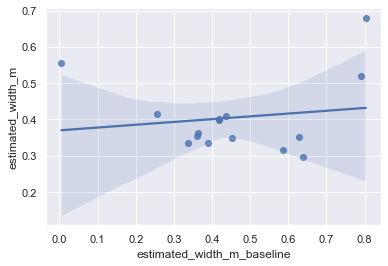

In [435]:
sns.regplot(x="estimated_width_m_baseline", y="estimated_width_m", data=combined_df)

In [76]:
wandb.finish()